## Informer Demonstration
In this notebook I will show how to replicate the Informer paper's univariate forecasting specifications, point out what I adapted in the original Informer module and show how to make the model work with synthetic data.

Refer to comments marked with #B.A. - in the `exp_informer.py` and `data_loader.py` modules to see my comments on what I changed. The new functionalities are used in the Notebook.

### General Imports

In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import numpy as np
import pandas as pd
import sklearn
import torch

In [2]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [3]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer

### Replication: 96-Predict-24 Univariate Forecasting for ETTh1

**Model aguments** 

From the demo Notebook they provided in their GitHub I changed the following points in the model arguments:
- Set `args.model` to `ìnformerstack` - this is what they used in the paper
- Switched `features` to `S` for univariate-predicts-univariate task (autoregressive forecasting)
- Switched `args.enc_in`, `args.dec_in` and `args.c_out` to 1 (univariate) instead of 7 (all seven features from the dataset)
- Changed `args.e_layers` to `args.s_layers` as required for using `informerstack` instead of `informer`
- Increased `args.d_layers` from 1 to 2, because they used 2 in the paper.
- Increased `args.train_epochs` from 6 to 8, because they used 8 in the paper.

In [4]:
args = dotdict()

args.model = 'informerstack' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'ETTh1' # data
args.root_path = './ETDataset/ETT-small/' # root path of data file
args.data_path = 'ETTh1.csv' # data file
args.features = 'S' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

# Changed 7-s to 1-s for univariate predict univariate
args.enc_in = 1 # encoder input size
args.dec_in = 1 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
# Change from e_layers = whatever to s_layers for informer stack
args.s_layers = [3, 2, 1] # num of encoder layers
# Upped to 2 
args.d_layers = 2 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32 
args.learning_rate = 1e-4
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
# B.A. - Paper says they trained for 8 epochs
args.train_epochs = 8
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

**GPU Handling**

I did not change anything here.

In [5]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

**Data Parser**:

I added `SYNTHh1` and `SYNTHh2` in the data parsing code so that it can handle our synthetic data as well.

In [6]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'SYNTHh1':{'data':'SYNTHh1.csv','T':'TARGET','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'SYNTHh2':{'data':'SYNTHh2.csv','T':'TARGET','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

**Importing the Model:**

Nothing changed here.

In [7]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [8]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informerstack', 'data': 'ETTh1', 'root_path': './ETDataset/ETT-small/', 'data_path': 'ETTh1.csv', 'features': 'S', 'target': 'OT', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 1, 'dec_in': 1, 'c_out': 1, 'factor': 5, 'd_model': 512, 'n_heads': 8, 's_layers': [3, 2, 1], 'd_layers': 2, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 8, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [9]:
Exp = Exp_Informer

**Model Training:**

I adapted the original modules so that it allows for returning the predictions, true values, mse and mae results and the first batch of the test set inputs.

In [10]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.s_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)
    # changed to s_layers -- in args
    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    
    ### Added returns to the train function should allow the return of train, val and test datasets 
    model = exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    
    # B.A. - Since I added returns to the training class
    # We can now return prediction windows, true value windows and metrics
    y_pred_24, y_true_24, mse_24, mae_24, first_batch_test = exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informerstack_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 8521
val 2857
test 2857
	iters: 100, epoch: 1 | loss: 0.1253693
	speed: 0.1942s/iter; left time: 394.0318s
	iters: 200, epoch: 1 | loss: 0.0828214
	speed: 0.1453s/iter; left time: 280.3750s
Epoch: 1 cost time: 42.76646876335144
Epoch: 1, Steps: 266 | Train Loss: 0.1609436 Vali Loss: 0.0733239 Test Loss: 0.0591664
Validation loss decreased (inf --> 0.073324).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1198083
	speed: 0.3370s/iter; left time: 594.0813s
	iters: 200, epoch: 2 | loss: 0.1174485
	speed: 0.1461s/iter; left time: 243.0330s
Epoch: 2 cost time: 38.82037162780762
Epoch: 2, Steps: 266 | Train Loss: 0.0933164 Vali Loss: 0.0814397 Test Loss: 0.1502360
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.0865135
	speed: 

### What We can Do With New Functionalities:

Firstly, now we can just inspect the data shapes and make sure nothing is going wrong at any step.

For example:

In [ ]:
### So the encoder input shaope
print(first_batch_test['batch_x'].shape)

### decoder input shape
print(first_batch_test['batch_y'].shape)

### The time feature shapes
## For hourly data the four features are
# [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
print(first_batch_test['batch_x_mark'].shape)
print(first_batch_test['batch_y_mark'].shape)

torch.Size([32, 96, 1])
torch.Size([32, 72, 1])
torch.Size([32, 96, 4])
torch.Size([32, 72, 4])


In [ ]:
## Inspect the time features for the second observation in the first batch
first_batch_test['batch_x_mark'][0][1]

tensor([ 0.5000, -0.3333,  0.0000, -0.1301], dtype=torch.float64)

In [12]:
## By all means, the time features for the first observation in the second batch
# should equal that displayed above  

all(first_batch_test['batch_x_mark'][0][1] == first_batch_test['batch_x_mark'][1][0])

True

In [13]:
print(y_pred_24.shape)
print(y_true_24.shape)

(2848, 24, 1)
(2848, 24, 1)


Having the MSE values saved as variables will allow us to do some plots once we have 96-predict-24, 96-predict-48, ..., 96-predict-720 scenarios all in one place.

In [16]:
print(mse_24)

0.077734634


Let us visualize the first and the last window of predictions

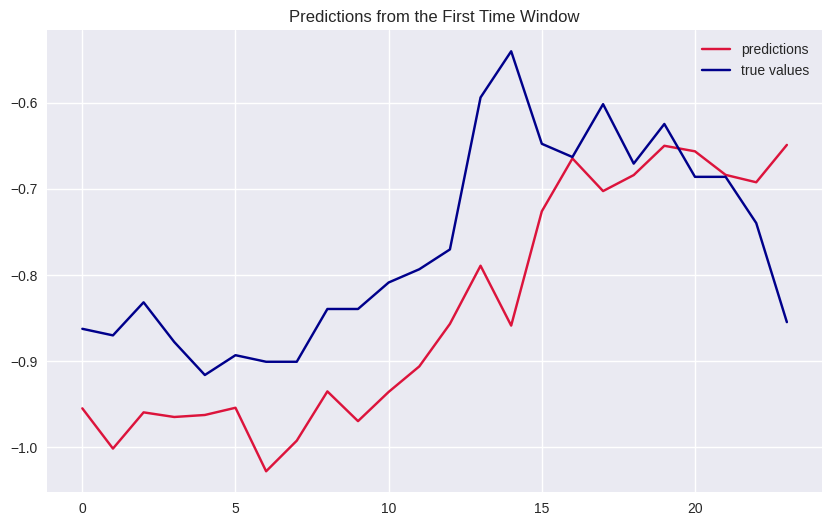

In [14]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))
plt.plot(y_pred_24[0, :, 0],  c='crimson', label='predictions')
plt.plot(y_true_24[0, :, 0], c='darkblue', label='true values')
plt.title('Predictions from the First Time Window')
plt.legend()
plt.show()

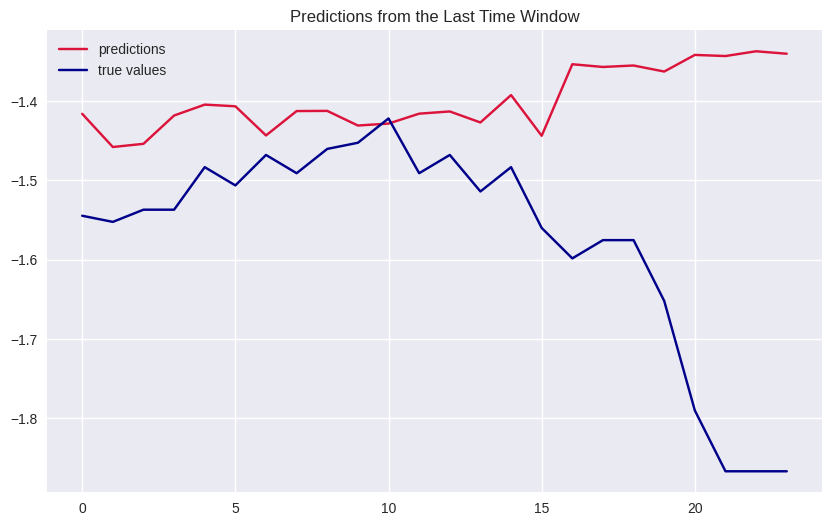

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(y_pred_24[-1, :, -1],  c='crimson', label='predictions')
plt.plot(y_true_24[-1, :, -1], c='darkblue', label='true values')
plt.title('Predictions from the Last Time Window')
plt.legend()
plt.show()

### New: 96-Predict-24 Univariate Forecasting for Synthetic Hourly Data

This is essentially the same as the code I ran below, just the `args.data`, `args.root_path` and `args.data_path` are changed to the synthetic set.

In [17]:
args = dotdict()

args.model = 'informerstack' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'SYNTHh1' # data
args.root_path = './SYNTHDataset/' # root path of data file
args.data_path = 'SYNTHh1.csv' # data file
args.features = 'S' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'TARGET' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

# Changed 7-s to 1-s for univariate predict univariate
args.enc_in = 1 # encoder input size
args.dec_in = 1 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
# Change from e_layers = whatever to s_layers for informer stack
args.s_layers = [3, 2, 1] # num of encoder layers
# Upped to 2 
args.d_layers = 2 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32 
args.learning_rate = 1e-4
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
# B.A. - Paper says they trained for 8 epochs
args.train_epochs = 8
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [18]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

**Data Parser**:

I added `SYNTHh1` and `SYNTHh2` in the data parsing code so that it can handle our synthetic data as well.

In [19]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'SYNTHh1':{'data':'SYNTHh1.csv','T':'TARGET','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'SYNTHh2':{'data':'SYNTHh2.csv','T':'TARGET','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [20]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [21]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informerstack', 'data': 'SYNTHh1', 'root_path': './SYNTHDataset/', 'data_path': 'SYNTHh1.csv', 'features': 'S', 'target': 'TARGET', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 1, 'dec_in': 1, 'c_out': 1, 'factor': 5, 'd_model': 512, 'n_heads': 8, 's_layers': [3, 2, 1], 'd_layers': 2, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 8, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [22]:
Exp = Exp_Informer

In [23]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.s_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)
    # changed to s_layers -- in args
    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    
    ### Added returns to the train function should allow the return of train, val and test datasets 
    model = exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    
    # B.A. - Since I added returns to the training class
    # We can now return prediction windows, true value windows and metrics
    y_pred_24, y_true_24, mse_24, mae_24, first_batch_test = exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informerstack_SYNTHh1_ftS_sl96_ll48_pl24_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 8521
val 2857
test 2857
	iters: 100, epoch: 1 | loss: 0.0906604
	speed: 0.1420s/iter; left time: 288.1347s
	iters: 200, epoch: 1 | loss: 0.0535985
	speed: 0.1128s/iter; left time: 217.5572s
Epoch: 1 cost time: 35.50484561920166
Epoch: 1, Steps: 266 | Train Loss: 0.1709997 Vali Loss: 0.0377204 Test Loss: 0.0399970
Validation loss decreased (inf --> 0.037720).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.0509146
	speed: 0.3516s/iter; left time: 619.8424s
	iters: 200, epoch: 2 | loss: 0.0515283
	speed: 0.1500s/iter; left time: 249.3802s
Epoch: 2 cost time: 39.82508397102356
Epoch: 2, Steps: 266 | Train Loss: 0.0386736 Vali Loss: 0.0322735 Test Loss: 0.0332175
Validation loss decreased (0.037720 --> 0.032274).  Saving model ...
Updating learning rate to 5e-05
	iters: 100

In [24]:
### So the encoder input shaope
print(first_batch_test['batch_x'].shape)

### decoder input shape
print(first_batch_test['batch_y'].shape)

### The time feature shapes
## For hourly data the four features are
# [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
print(first_batch_test['batch_x_mark'].shape)
print(first_batch_test['batch_y_mark'].shape)

torch.Size([32, 96, 1])
torch.Size([32, 72, 1])
torch.Size([32, 96, 4])
torch.Size([32, 72, 4])


In [25]:
## Inspect the time features for the second observation in the first batch
first_batch_test['batch_x_mark'][0][1]

tensor([ 0.5000, -0.3333,  0.0000, -0.1301], dtype=torch.float64)

In [26]:
## By all means, the time features for the first observation in the second batch
# should equal that displayed above  

all(first_batch_test['batch_x_mark'][0][1] == first_batch_test['batch_x_mark'][1][0])

True

In [27]:
print(y_pred_24.shape)
print(y_true_24.shape)

(2848, 24, 1)
(2848, 24, 1)


Let us visualize the first and the last window of predictions

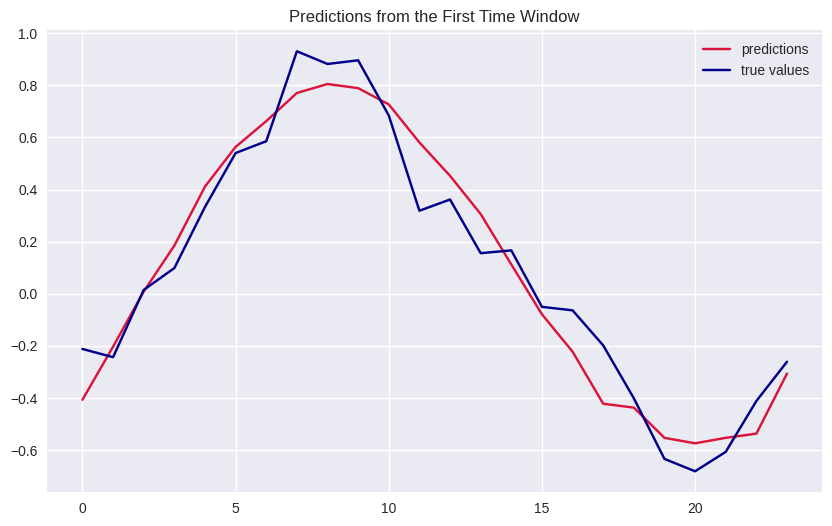

In [28]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))
plt.plot(y_pred_24[0, :, 0],  c='crimson', label='predictions')
plt.plot(y_true_24[0, :, 0], c='darkblue', label='true values')
plt.title('Predictions from the First Time Window')
plt.legend()
plt.show()

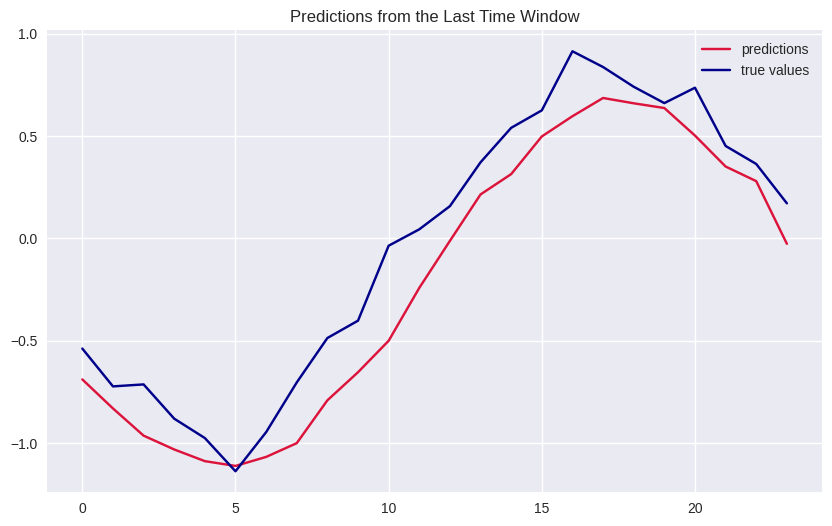

In [29]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))
plt.plot(y_pred_24[-1, :, -1],  c='crimson', label='predictions')
plt.plot(y_true_24[-1, :, -1], c='darkblue', label='true values')
plt.title('Predictions from the Last Time Window')
plt.legend()
plt.show()

### New: 96-Predict-24 Univariate Forecasting for Hourly Wind Data

This is essentially the same as the code I ran below, just the `args.data`, `args.root_path` and `args.data_path` are changed to the wind set.

In [4]:
args = dotdict()

args.model = 'informerstack' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'DEWINDh_small' # data
args.root_path = './WINDataset/' # root path of data file
args.data_path = 'DEWINDh_small.csv' # data file
args.features = 'S' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'TARGET' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

# Changed 7-s to 1-s for univariate predict univariate
args.enc_in = 1 # encoder input size
args.dec_in = 1 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
# Change from e_layers = whatever to s_layers for informer stack
args.s_layers = [3, 2, 1] # num of encoder layers
# Upped to 2 
args.d_layers = 2 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32 
args.learning_rate = 1e-4
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
# B.A. - Paper says they trained for 8 epochs
args.train_epochs = 8
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [5]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

**Data Parser**:

I added `DEWINDh_large` and `DEWINDh_small` in the data parsing code so that it can handle our synthetic data as well.

In [6]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'SYNTHh1':{'data':'SYNTHh1.csv','T':'TARGET','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'SYNTHh2':{'data':'SYNTHh2.csv','T':'TARGET','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'DEWINDh_large':{'data':'DEWINDh_large.csv','T':'TARGET','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'DEWINDh_small':{'data':'DEWINDh_small.csv','T':'TARGET','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [7]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [8]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informerstack', 'data': 'DEWINDh_small', 'root_path': './WINDataset/', 'data_path': 'DEWINDh_small.csv', 'features': 'S', 'target': 'TARGET', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 1, 'dec_in': 1, 'c_out': 1, 'factor': 5, 'd_model': 512, 'n_heads': 8, 's_layers': [3, 2, 1], 'd_layers': 2, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 8, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [9]:
Exp = Exp_Informer

In [10]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.s_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)
    # changed to s_layers -- in args
    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    
    ### Added returns to the train function should allow the return of train, val and test datasets 
    model = exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    
    # B.A. - Since I added returns to the training class
    # We can now return prediction windows, true value windows and metrics
    # the original code did not have anything removed, so the returns are also being saved as np arrays as they used to
    y_pred_24, y_true_24, mse_24, mae_24, first_batch_test = exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informerstack_DEWINDh_small_ftS_sl96_ll48_pl24_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 8521
val 2857
test 2857
	iters: 100, epoch: 1 | loss: 0.2330617
	speed: 0.0930s/iter; left time: 188.6978s
	iters: 200, epoch: 1 | loss: 0.1967499
	speed: 0.0841s/iter; left time: 162.2040s
Epoch: 1 cost time: 22.855731964111328
Epoch: 1, Steps: 266 | Train Loss: 0.2804496 Vali Loss: 0.1914816 Test Loss: 0.2050871
Validation loss decreased (inf --> 0.191482).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.0957064
	speed: 0.1935s/iter; left time: 341.2101s
	iters: 200, epoch: 2 | loss: 0.0940709
	speed: 0.0841s/iter; left time: 139.7916s
Epoch: 2 cost time: 22.355114698410034
Epoch: 2, Steps: 266 | Train Loss: 0.1371941 Vali Loss: 0.1578264 Test Loss: 0.1531660
Validation loss decreased (0.191482 --> 0.157826).  Saving model ...
Updating learning rate to 5e-05
	it

In [11]:
### So the encoder input shaope
print(first_batch_test['batch_x'].shape)

### decoder input shape
print(first_batch_test['batch_y'].shape)

### The time feature shapes
## For hourly data the four features are
# [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
print(first_batch_test['batch_x_mark'].shape)
print(first_batch_test['batch_y_mark'].shape)

torch.Size([32, 96, 1])
torch.Size([32, 72, 1])
torch.Size([32, 96, 4])
torch.Size([32, 72, 4])


In [12]:
## Inspect the time features for the second observation in the first batch
first_batch_test['batch_x_mark'][0][1]

tensor([-0.2826,  0.5000,  0.3333, -0.1849], dtype=torch.float64)

In [13]:
## By all means, the time features for the first observation in the second batch
# should equal that displayed above  

all(first_batch_test['batch_x_mark'][0][1] == first_batch_test['batch_x_mark'][1][0])

True

In [14]:
print(y_pred_24.shape)
print(y_true_24.shape)

(2848, 24, 1)
(2848, 24, 1)


Let us visualize the first and the last window of predictions

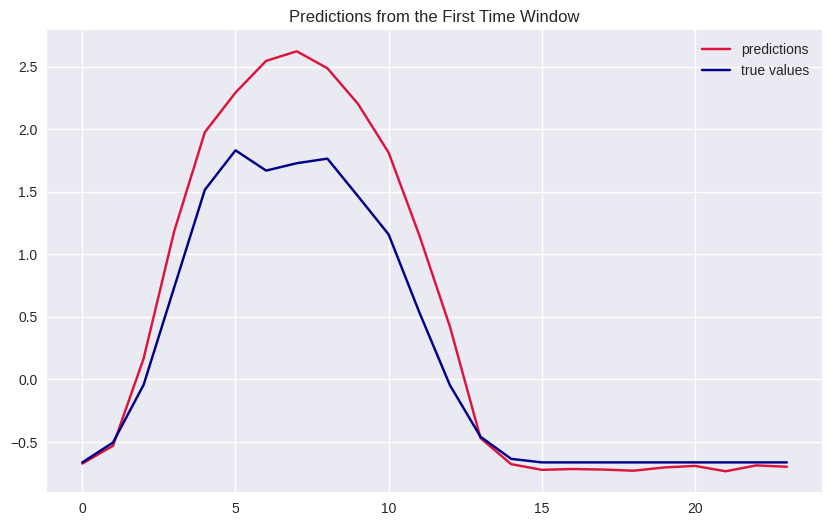

In [15]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))
plt.plot(y_pred_24[0, :, 0],  c='crimson', label='predictions')
plt.plot(y_true_24[0, :, 0], c='darkblue', label='true values')
plt.title('Predictions from the First Time Window')
plt.legend()
plt.show()

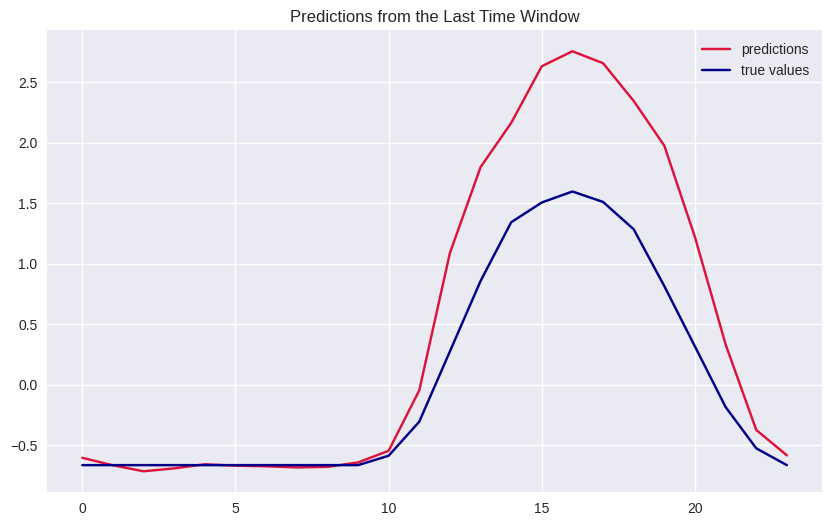

In [16]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))
plt.plot(y_pred_24[-1, :, -1],  c='crimson', label='predictions')
plt.plot(y_true_24[-1, :, -1], c='darkblue', label='true values')
plt.title('Predictions from the Last Time Window')
plt.legend()
plt.show()

*Reminder to self:* Since the wind data is more sparse - the load cycles are afar from each other with relatively length periods with 0 output inbetween, it may be a better idea to model them with longer encoder input lengths. 